In [1]:
import sys, os
sys.path.append(os.path.realpath(".."))

import util_funcs
from importlib import reload
reload(util_funcs)
from copy import deepcopy as cp

import data_reader as read
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import pywt
import tsfresh.feature_extraction.feature_calculators as feats
import constants
import clinical_text_analysis as cta
reload(cta)
import tsfresh
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from os import path

reload(read)
import wf_analysis.datasets as wfdata
import wf_analysis.filters as filt
reload(filt)
import time

# Check and see if there were patients shared between splits

In [126]:
devTestPatients = read.get_patient_dir_names("dev_test", "01_tcp_ar", full_path=False)
trainPatients = read.get_patient_dir_names("train", "01_tcp_ar", full_path=False)

In [127]:
set(devTestPatients).intersection(set(trainPatients))

{'00004671', '00006546', '00009842'}

there may be different patients having sessions on same day, but we check and find that there weren't same patients havign same session on same day between splits

In [128]:

devTestSessions = read.get_session_dir_names("dev_test", "01_tcp_ar", full_path=False, patient_dirs=["/home/ms994/v1.5.0/edf/dev_test/01_tcp_ar/046/00004671", "/home/ms994/v1.5.0/edf/dev_test/01_tcp_ar/065/00006546", "/home/ms994/v1.5.0/edf/dev_test/01_tcp_ar/098/00009842"])
trainSessions = read.get_session_dir_names("train", "01_tcp_ar", full_path=False, patient_dirs=["/home/ms994/v1.5.0/edf/train/01_tcp_ar/046/00004671", "/home/ms994/v1.5.0/edf/train/01_tcp_ar/065/00006546", "/home/ms994/v1.5.0/edf/train/01_tcp_ar/098/00009842"])
set(devTestSessions).intersection(set(trainSessions))

set()

In [129]:
set(devTestSessions).intersection(set(trainSessions))

set()

# Compare dev test split and train split cached file info with cached sampling info

In [2]:
#cached info used for the classification task
trainDataGenders= pkl.load(open("../simple_ensemble_train_data_max_length_4.pkl", 'rb'))
devTestDataGenders= pkl.load(open("../simple_ensemble_test_data_max_length_4.pkl", 'rb'))

In [3]:
# cached info on how each sample in the data was generated 
# (we split token file into n by 500 non overlapping choices and we pick at most 40 of em)
trainSamplingInfo = pkl.load(open("../native_edf_ensemble_path.pkl", 'rb'))
devTestSamplingInfo = pkl.load(open("../test_native_edf_ensemble_path.pkl", 'rb'))

In [132]:
#confirm that the samplingInfo is correct
trainDataReader = read.EdfDataset("train", "01_tcp_ar", expand_tse=False)
trainDataReader.edf_tokens = [trainSamplingInfo[i].token_file_path for i in range(len(trainSamplingInfo))]
data, label = trainDataReader[0]


In [133]:
trainDataReader.edf_tokens[0]

'/home/ms994/v1.5.0/edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/00008303_s003_t000.edf'

In [134]:
trainSamplingInfo[0]

{'token_file_path': '/home/ms994/v1.5.0/edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/00008303_s003_t000.edf',
 'sample_num': 9,
 'within_token_num': 0,
 'label': 0}

In [135]:
pd.DataFrame(trainDataGenders[0][0]).head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,-17.086330,-14.110868,-33.870987,-22.426903,-38.753792,-31.200699,-3.200843,-1.751259,-23.876486,-1.064614,...,1.147908,-23.723898,-18.841091,-44.323246,10.684644,-49.434937,-19.527735,-38.830086,-14.568632,-48.824585
1,-16.475979,-14.416044,-34.405045,21.289495,-38.372326,-31.353287,-2.895668,-1.827553,-23.495018,-1.674966,...,0.842733,-23.418722,-18.459621,-44.552128,10.455763,-49.816406,-18.841091,-39.058968,-13.653105,-48.671997
2,-16.552273,-14.416044,-33.489517,-28.530415,-36.922741,-31.124405,-3.353431,-0.759439,-21.892845,-1.446084,...,1.300496,-21.892845,-18.841091,-43.560310,10.074293,-48.977173,-19.298853,-38.448620,-12.508698,-48.137943
3,-15.636746,-14.110868,-32.726578,28.842588,-36.922741,-31.124405,-2.590492,-0.072794,-21.358788,-1.522378,...,2.139729,-21.053612,-17.849270,-43.712898,10.150587,-49.740112,-18.230740,-38.372326,-11.516876,-48.595707
4,-16.323391,-14.797514,-32.116226,-34.176163,-35.625744,-31.048111,-3.506019,1.605672,-19.069971,-1.827553,...,2.139729,-19.451441,-18.459621,-43.712898,10.837233,-48.748291,-19.069971,-38.372326,-10.296175,-47.146122


In [136]:
segmentSize = constants.COMMON_FREQ * 4

In [137]:
segmentSize

500

In [138]:
data.iloc[9*segmentSize:10*segmentSize]

,EEG T5-REF,EEG C3-REF,EEG A1-REF,EEG P4-REF,EEG F8-REF,EEG F3-REF,EEG CZ-REF,EEG O2-REF,EEG A2-REF,EEG P3-REF,...,EEG O1-REF,EEG T4-REF,EEG F4-REF,EEG F7-REF,EEG PZ-REF,EEG FP1-REF,EEG FZ-REF,EEG T3-REF,EEG T6-REF,EEG FP2-REF
00:00:36,-17.086330,-14.110868,-33.870987,-22.426903,-38.753792,-31.200699,-3.200843,-1.751259,-23.876486,-1.064614,...,1.147908,-23.723898,-18.841091,-44.323246,10.684644,-49.434937,-19.527735,-38.830086,-14.568632,-48.824585
00:00:36.008000,-16.475979,-14.416044,-34.405045,21.289495,-38.372326,-31.353287,-2.895668,-1.827553,-23.495018,-1.674966,...,0.842733,-23.418722,-18.459621,-44.552128,10.455763,-49.816406,-18.841091,-39.058968,-13.653105,-48.671997
00:00:36.016000,-16.552273,-14.416044,-33.489517,-28.530415,-36.922741,-31.124405,-3.353431,-0.759439,-21.892845,-1.446084,...,1.300496,-21.892845,-18.841091,-43.560310,10.074293,-48.977173,-19.298853,-38.448620,-12.508698,-48.137943
00:00:36.024000,-15.636746,-14.110868,-32.726578,28.842588,-36.922741,-31.124405,-2.590492,-0.072794,-21.358788,-1.522378,...,2.139729,-21.053612,-17.849270,-43.712898,10.150587,-49.740112,-18.230740,-38.372326,-11.516876,-48.595707
00:00:36.032000,-16.323391,-14.797514,-32.116226,-34.176163,-35.625744,-31.048111,-3.506019,1.605672,-19.069971,-1.827553,...,2.139729,-19.451441,-18.459621,-43.712898,10.837233,-48.748291,-19.069971,-38.372326,-10.296175,-47.146122
00:00:36.040000,-15.865627,-14.110868,-31.887344,34.106869,-34.633923,-30.590347,-1.980141,2.368610,-17.849270,-1.674966,...,2.444904,-18.459621,-16.247097,-43.331429,11.981640,-49.053467,-17.544094,-38.753796,-9.304354,-47.069828
00:00:36.048000,-17.162624,-14.721220,-30.971817,-36.159801,-34.176159,-30.971817,-3.353431,2.673786,-17.086330,-1.827553,...,2.216023,-18.154446,-17.696682,-43.789192,11.447583,-48.366825,-19.222559,-38.906380,-8.083652,-46.612064
00:00:36.056000,-16.247097,-14.187162,-32.192520,38.379326,-34.405041,-30.437759,-1.827553,2.597492,-17.086330,-1.751259,...,2.368610,-17.925564,-16.475979,-43.407722,11.752758,-48.595703,-17.315212,-38.524914,-7.778476,-46.840946
00:00:36.064000,-15.560452,-14.721220,-29.369646,-35.320568,-35.091686,-30.819229,-4.040076,3.207843,-16.628567,-1.446084,...,3.131549,-18.993677,-18.993677,-43.255135,10.532057,-47.832767,-19.604029,-36.846447,-8.007358,-47.451298
00:00:36.072000,-14.416044,-13.500518,-29.979996,38.913383,-34.862804,-30.208879,-1.903847,2.978961,-17.467800,-0.988321,...,3.436725,-18.841089,-16.552273,-42.110725,11.447582,-47.909061,-17.086330,-36.770153,-8.312533,-46.612064


In [139]:
#confirm that the samplingInfo is correct
devTestDataReader = read.EdfDataset("dev_test", "01_tcp_ar", expand_tse=False)
devTestDataReader.edf_tokens = [devTestSamplingInfo[i].token_file_path for i in range(len(devTestSamplingInfo))]
data, label = devTestDataReader[0]

In [141]:
devTestDataReader.edf_tokens[0]

'/home/ms994/v1.5.0/edf/dev_test/01_tcp_ar/069/00006986/s001_2010_09_30/00006986_s001_t000.edf'

In [119]:
devTestSamplingInfo[2] #??? Got reset somehow but shouldn't affect. TODO: fix this bug?

{'token_file_path': '/home/ms994/v1.5.0/edf/dev_test/01_tcp_ar/069/00006986/s001_2010_09_30/00006986_s001_t000.edf',
 'sample_num': 9,
 'within_token_num': 2,
 'label': 0}

In [120]:
pd.DataFrame(devTestDataGenders[2][0]).head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,9.769117,9.158766,3.360431,9.006178,5.801835,15.185984,6.183305,1.758259,3.665606,13.736399,...,1.224202,4.581133,19.839911,11.752758,5.878129,8.243239,5.954423,9.845411,4.810015,3.055255
1,-0.912027,-1.827553,-7.854770,3.894488,-0.759439,2.597492,-4.192664,-3.658607,-3.124549,1.681965,...,-10.753938,3.665606,13.583812,-2.056435,-3.353431,-3.658607,-2.895668,-2.514198,2.597492,-8.159945
2,-0.988320,-1.903847,-7.244419,9.692823,3.131549,3.665606,-4.268958,-1.522378,3.055255,2.902668,...,-10.601350,11.142406,14.957102,-4.421546,-1.522378,-2.132729,-2.971961,-4.192664,8.777297,-6.862950
3,-5.031897,-5.871129,-9.990999,9.692823,2.521198,0.156088,-6.634068,-3.048255,4.352252,0.156088,...,-14.644926,11.218701,11.981640,-6.939243,-1.293496,-3.506019,-6.862949,-8.465121,7.861770,-5.337072
4,3.284137,4.428545,-5.489660,17.245918,10.074293,10.379469,3.513019,7.938064,9.769117,9.082473,...,-1.140908,16.101509,19.992496,-1.674966,6.946244,4.199664,3.665606,-2.285316,14.346750,2.216023


In [117]:
data.iloc[0:-1:segmentSize].reset_index()

,index,EEG T5-REF,EEG C3-REF,EEG A1-REF,EEG P4-REF,EEG F8-REF,EEG F3-REF,EEG CZ-REF,EEG O2-REF,EEG A2-REF,...,EEG O1-REF,EEG T4-REF,EEG F4-REF,EEG F7-REF,EEG PZ-REF,EEG FP1-REF,EEG FZ-REF,EEG T3-REF,EEG T6-REF,EEG FP2-REF
0,00:00:00,65.692535,140.536835,138.705780,119.327133,102.847656,130.771225,142.215302,129.550522,131.610458,...,148.242523,129.626816,64.014069,120.929306,159.915482,131.381577,132.831161,132.144516,138.095428,111.468872
1,00:00:04,9.540236,57.223915,58.978676,48.068649,49.213058,53.180340,54.858803,47.153122,55.850624,...,51.425575,51.807049,25.561951,50.052288,62.564487,55.926918,48.068649,47.305710,55.316566,48.144943
2,00:00:08,-147.625168,-155.788605,-129.924988,-145.717819,-137.249207,-148.159225,-143.657898,-150.905807,-142.589783,...,-137.706970,-139.766907,-155.483429,-140.148376,-140.072083,-154.491608,-148.540695,-135.570740,-148.693283,-161.586945
3,00:00:12,-62.252312,-57.598381,-61.870842,-43.102547,-50.655640,-58.742790,-46.917240,-54.012573,-54.241455,...,-55.309570,-49.968994,-57.750969,-70.873520,-42.187019,-65.380356,-49.434937,-65.075180,-49.282349,-62.252312
4,00:00:16,30.826229,19.992498,27.087830,20.984318,17.627388,24.951601,20.297672,19.458441,17.169624,...,20.373966,20.679142,34.412041,29.605528,16.254097,40.210381,27.698181,38.837090,24.722719,40.668144
5,00:00:20,6.412187,-4.650427,-0.072794,-0.606851,-1.522378,-2.285316,-8.236239,0.613851,-2.361610,...,-4.040076,6.869950,2.902668,4.504839,-6.710362,-3.963782,-5.947423,2.978962,2.826374,0.232382
6,00:00:24,21.213200,31.665462,23.730900,32.962460,36.548271,36.243095,24.341251,29.834410,32.657284,...,27.774475,32.962460,40.820728,33.343925,28.384827,48.602707,29.376644,21.899845,31.665462,56.384682
7,00:00:28,9.769117,9.158766,3.360431,9.006178,5.801835,15.185984,6.183305,1.758259,3.665606,...,1.224202,4.581133,19.839911,11.752758,5.878129,8.243239,5.954423,9.845411,4.810015,3.055255
8,00:00:32,-61.031609,-61.336784,-58.132439,-63.091541,-30.437761,-60.802727,-68.813583,-65.532944,-52.181519,...,-66.829941,-51.418579,-67.974350,-52.791870,-63.473011,-59.810905,-66.219589,-57.293205,-60.879021,-68.050644
9,00:00:36,25.027895,15.491158,25.409363,11.829052,19.534735,14.880808,7.556595,20.602848,33.572811,...,31.131405,29.834408,21.213200,17.856270,9.082472,25.027895,7.861770,23.044254,24.493837,17.551094


# Compare distribution of genders

In [4]:
trainGenders = [datum[1] for datum in trainDataGenders]
trainData = np.stack([datum[0] for datum in trainDataGenders])
devTestData = np.stack([datum[0] for datum in devTestDataGenders])
devTestGenders = np.stack([datum[1] for datum in devTestDataGenders])

In [5]:
np.mean(trainGenders), np.mean(devTestGenders) # almost 50% male in train set, 72% male in dev_test

(0.5002429663714708, 0.7279160238781944)

In [6]:
len(trainGenders), len(devTestGenders)

(100837, 29818)

In [7]:
trainData.shape, devTestData.shape

((100837, 500, 21), (29818, 500, 21))

In [12]:
meanDiff = trainData.reshape(100837 * 500, 21).mean(axis=0) - devTestData.reshape(29818 * 500, 21).mean(axis=0)  
meanDiff

array([ 0.9387026 , -0.2793789 , -2.6633878 ,  1.1775446 ,  1.0293641 ,
        1.3413162 , -0.716166  ,  1.1384773 , -1.5613184 , -0.2163992 ,
        0.31405497, -0.7469444 ,  1.9576583 ,  0.6698208 , -1.7037859 ,
       -1.32306   ,  0.7989192 , -0.8475666 , -0.96716785,  0.5588398 ,
        0.9364414 ], dtype=float32)

In [15]:
zScoreDiff = trainData.reshape(100837 * 500, 21).mean(axis=0)/ trainData.reshape(100837 * 500, 21).std(axis=0) - devTestData.reshape(29818 * 500, 21).mean(axis=0)/devTestData.reshape(29818 * 500, 21).std(axis=0)  
zScoreDiff

array([ 0.02680381,  0.01881197, -0.00323022,  0.05704791,  0.04171841,
        0.03213822,  0.01320438,  0.02504704, -0.00413765,  0.02443267,
        0.05249136,  0.00508873,  0.04997452,  0.05548088,  0.00962117,
       -0.00233571,  0.05045075,  0.00227151,  0.02650644,  0.04014965,
        0.01641723], dtype=float32)

(array([5482.288, 5482.288, 5482.288, 5482.288, 5482.288, 5482.288,
        5482.288, 5482.288, 5482.288, 5482.288, 5482.288, 5482.288,
        5482.288, 5482.288, 5482.288, 5482.288, 5482.288, 5482.288,
        5482.288, 5482.288, 5482.288], dtype=float32),
 array([5482.288, 5482.288, 5482.288, 5482.288, 5482.288, 5482.288,
        5482.288, 5482.288, 5482.288, 5482.288, 5482.288, 5482.288,
        5482.288, 5482.288, 5482.288, 5482.288, 5482.288, 5482.288,
        5482.288, 5482.288, 5482.288], dtype=float32))

In [17]:
trainData.min(0).min(0), devTestData.min(0).min(0)

(array([-5482.4473, -5482.4473, -5482.4473, -5482.4473, -5482.4473,
        -5482.4473, -5482.4473, -5482.4473, -5482.4473, -5482.4473,
        -5482.4473, -5482.4473, -5482.4473, -5482.4473, -5482.4473,
        -5482.4473, -5482.4473, -5482.4473, -5482.4473, -5482.4473,
        -5482.4473], dtype=float32),
 array([-5482.4473, -5482.4473, -5482.4473, -5482.4473, -5482.4473,
        -5482.4473, -5482.4473, -5482.4473, -5482.4473, -5482.4473,
        -5482.4473, -5482.4473, -5482.4473, -5482.4473, -5482.4473,
        -5482.4473, -5482.4473, -5482.4473, -5482.4473, -5482.4473,
        -5482.4473], dtype=float32))

(array([8.03411000e+05, 7.22960000e+05, 9.34709000e+05, 2.44372700e+06,
        6.94829671e+08, 3.54025776e+08, 2.44471900e+06, 9.90845000e+05,
        7.42488000e+05, 8.50194000e+05]),
 array([-5.4824473e+03, -4.3859736e+03, -3.2895002e+03, -2.1930266e+03,
        -1.0965531e+03, -7.9589844e-02,  1.0963939e+03,  2.1928674e+03,
         3.2893411e+03,  4.3858145e+03,  5.4822881e+03], dtype=float32),
 <a list of 10 Patch objects>)

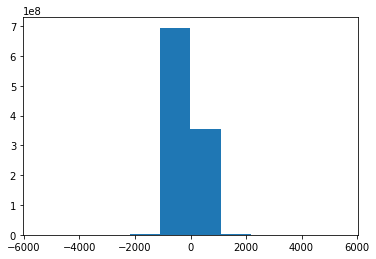

In [18]:
plt.hist(trainData.flatten())

(array([7.21290000e+04, 8.41460000e+04, 1.24791000e+05, 2.87688000e+05,
        2.02990409e+08, 1.08910082e+08, 3.17659000e+05, 1.32185000e+05,
        8.20030000e+04, 8.79080000e+04]),
 array([-5.4824473e+03, -4.3859736e+03, -3.2895002e+03, -2.1930266e+03,
        -1.0965531e+03, -7.9589844e-02,  1.0963939e+03,  2.1928674e+03,
         3.2893411e+03,  4.3858145e+03,  5.4822881e+03], dtype=float32),
 <a list of 10 Patch objects>)

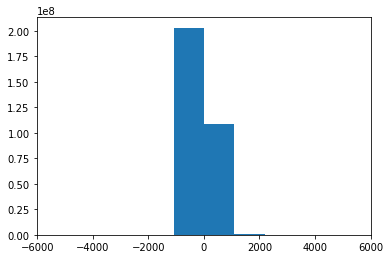

In [19]:
plt.hist(devTestData.flatten())

# check combined

In [49]:
reload(cta)
trainTokens, validTokens, testTokens, trainGenders, validGenders, testGenders = pkl.load(open("/home/ms994/dbmi_eeg_clustering/train_test_split_info.pkl", 'rb'))

In [52]:
validGenders

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [16]:
len(trainTokens), len(validTokens), len(testTokens), len(trainGenders), len(validGenders), len(testGenders)

(1837, 841, 704, 1837, 841, 704)

In [17]:
trainSampleInfo = pkl.load(open("../edf_ensemble_path.pkl", 'rb'))

In [18]:
tfp = set([trainSampleInfo[key].token_file_path for key in trainSampleInfo.keys()])

In [19]:
tfp == set(trainTokens)

True

In [23]:
trainData = pkl.load(open("../combined_simple_ensemble_train_data.pkl", 'rb'))

In [21]:
len(trainSampleInfo.keys())

71409

In [24]:
len(trainData)

71409

In [29]:
validSampleInfo = pkl.load(open("../valid_edf_ensemble_path.pkl", 'rb'))

In [46]:
vfp = set([validSampleInfo[key].token_file_path for key in validSampleInfo.keys()])

In [47]:
vfp == set(validTokens)

True

In [25]:
validData = pkl.load(open("../valid_combined_simple_ensemble_train_data.pkl", 'rb'))

In [27]:
len(validData)

31987

In [30]:
len(validSampleInfo)

31987

In [17]:
set(trainTokens).intersection(testTokens)

set()

In [18]:
set(validTokens).intersection(testTokens)

set()

In [19]:
set(trainTokens).intersection(validTokens)

set()

In [20]:
len(set([fn[46:54] for fn in trainTokens + testTokens]))

267

In [49]:
[fn[46:71] for fn in trainTokens[0:10]]

['00002991/s003_2010_04_26/',
 '00002991/s003_2010_04_26/',
 '00000598/s006_2013_09_09/',
 '00000598/s006_2013_09_09/',
 '00012964/s001_2015_04_27/',
 '00012964/s002_2015_04_27/',
 '00012964/s002_2015_04_27/',
 '00012964/s002_2015_04_27/',
 '00012964/s002_2015_04_27/',
 '00012964/s002_2015_04_27/']

In [22]:
len(set([fn[46:54] for fn in trainTokens]).intersection(set([fn[46:54] for fn in validTokens])))

0

In [5]:
testTrainSplit[0][0][46:54]

'00009623'

In [9]:
reload(read)
read.parse_edf_token_path_structure(testTrainSplit[0][0])

('01_tcp_ar', '00009623', 's004_2012_10_19', '00009623_s004_t000.edf')

In [9]:
len(set([fn[46:71] for fn in testTrainSplit[0]]))

584

In [7]:
len(set([fn[46:71] for fn in testTrainSplit[0]]).intersection(set([fn[46:71] for fn in testTrainSplit[1]])))

281

In [10]:
set([fn[46:71] for fn in testTrainSplit[0]]).intersection(set([fn[46:71] for fn in testTrainSplit[1]]))

{'00000258/s002_2003_07_21/',
 '00000272/s007_2003_07_03/',
 '00000272/s008_2003_07_03/',
 '00000458/s011_2014_06_24/',
 '00000458/s012_2014_06_25/',
 '00000492/s003_2003_07_18/',
 '00000569/s006_2012_04_12/',
 '00000906/s001_2003_04_23/',
 '00000906/s002_2003_04_24/',
 '00000906/s016_2012_03_01/',
 '00000924/s002_2003_07_15/',
 '00001027/s004_2004_01_30/',
 '00001543/s002_2004_07_16/',
 '00001981/s007_2015_03_30/',
 '00001981/s008_2015_03_31/',
 '00001981/s009_2015_04_01/',
 '00002289/s003_2012_03_12/',
 '00002348/s011_2015_07_24/',
 '00002384/s002_2014_10_24/',
 '00002521/s002_2006_03_01/',
 '00002707/s001_2006_03_17/',
 '00003437/s006_2014_10_20/',
 '00003437/s007_2014_10_21/',
 '00003437/s011_2014_10_24/',
 '00004456/s015_2014_06_19/',
 '00004671/s011_2013_07_08/',
 '00004671/s022_2015_04_30/',
 '00005169/s007_2015_05_26/',
 '00005533/s006_2012_04_13/',
 '00005649/s003_2014_09_07/',
 '00006440/s002_2010_04_17/',
 '00006440/s004_2010_04_18/',
 '00006440/s005_2010_04_19/',
 '00006440

In [4]:
len(set([fn[46:71] for fn in testTrainSplit[0] + testTrainSplit[1]]))

759

In [43]:
len(testTrainSplit[0])

2705

# Didn't save test gender correctly, fixed it below

In [3]:
import keras

Using TensorFlow backend.


In [4]:
model = keras.models.load_model("../IACCDYSGMROCJNWR.h5")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [75]:
len(testData)

27259

In [47]:
trainData[0][1]

0

In [2]:
testData = pkl.load(open("../combined_simple_ensemble_test_data.pkl", 'rb'))

In [43]:
testSamplingInfo = pkl.load(open("../test_edf_ensemble_path.pkl", 'rb'))

In [66]:
genderFilenames = cta.demux_to_tokens(cta.getGenderAndFileNames("combined", "01_tcp_ar"))

In [70]:
genderFilenames = np.array(genderFilenames).transpose()

In [71]:
genderDict = {}
for fn, gend in genderFilenames:
    genderDict[fn] = 1 if gend == 'm' else 0
    if gend != 'm' and gend != 'f':
        raise Exception(gend)

In [ ]:
len(genderDict)

In [48]:
testGenders

['/home/ms994/v1.5.0/edf/combined/01_tcp_ar/000/00010591/s005_2013_08_11/00010591_s005_t000.edf',
 '/home/ms994/v1.5.0/edf/combined/01_tcp_ar/000/00010591/s005_2013_08_11/00010591_s005_t001.edf',
 '/home/ms994/v1.5.0/edf/combined/01_tcp_ar/000/00010591/s005_2013_08_11/00010591_s005_t002.edf',
 '/home/ms994/v1.5.0/edf/combined/01_tcp_ar/000/00010591/s005_2013_08_11/00010591_s005_t003.edf',
 '/home/ms994/v1.5.0/edf/combined/01_tcp_ar/000/00010591/s005_2013_08_11/00010591_s005_t004.edf',
 '/home/ms994/v1.5.0/edf/combined/01_tcp_ar/000/00010591/s005_2013_08_11/00010591_s005_t005.edf',
 '/home/ms994/v1.5.0/edf/combined/01_tcp_ar/000/00010591/s005_2013_08_11/00010591_s005_t006.edf',
 '/home/ms994/v1.5.0/edf/combined/01_tcp_ar/000/00010591/s002_2013_08_08/00010591_s002_t000.edf',
 '/home/ms994/v1.5.0/edf/combined/01_tcp_ar/000/00010591/s002_2013_08_08/00010591_s002_t001.edf',
 '/home/ms994/v1.5.0/edf/combined/01_tcp_ar/000/00010591/s002_2013_08_08/00010591_s002_t002.edf',
 '/home/ms994/v1.5.0

In [72]:
for i in testSamplingInfo.keys():
    testSamplingInfo[i].label = genderDict[testSamplingInfo[i].token_file_path]

In [79]:
len(testSamplingInfo)

27259

In [95]:
testSamplingInfo

{0: {'token_file_path': '/home/ms994/v1.5.0/edf/combined/01_tcp_ar/000/00010591/s005_2013_08_11/00010591_s005_t000.edf',
  'sample_num': 38,
  'within_token_num': 0,
  'label': 1},
 1: {'token_file_path': '/home/ms994/v1.5.0/edf/combined/01_tcp_ar/000/00010591/s005_2013_08_11/00010591_s005_t000.edf',
  'sample_num': 42,
  'within_token_num': 1,
  'label': 1},
 2: {'token_file_path': '/home/ms994/v1.5.0/edf/combined/01_tcp_ar/000/00010591/s005_2013_08_11/00010591_s005_t000.edf',
  'sample_num': 9,
  'within_token_num': 2,
  'label': 1},
 3: {'token_file_path': '/home/ms994/v1.5.0/edf/combined/01_tcp_ar/000/00010591/s005_2013_08_11/00010591_s005_t000.edf',
  'sample_num': 37,
  'within_token_num': 3,
  'label': 1},
 4: {'token_file_path': '/home/ms994/v1.5.0/edf/combined/01_tcp_ar/000/00010591/s005_2013_08_11/00010591_s005_t000.edf',
  'sample_num': 23,
  'within_token_num': 4,
  'label': 1},
 5: {'token_file_path': '/home/ms994/v1.5.0/edf/combined/01_tcp_ar/000/00010591/s005_2013_08_11/

In [74]:
pkl.dump(testSamplingInfo, open("../test_edf_ensemble_path.pkl", 'wb'))

In [83]:
testGend = [testSamplingInfo[i].label for i in range(len(testSamplingInfo))]

In [98]:
np.mean([testData[i][1] for i in range(len(testData))])

0.6386881396969808

In [87]:
for i in range(len(testData)):
    testData[i] = (testData[i][0], testGend[i])

In [99]:
pkl.dump(testData, open("../combined_simple_ensemble_test_data.pkl", 'wb'))b

In [5]:
testGender = [datum[1] for datum in testData]
testData = np.stack([datum[0] for datum in testData])

In [7]:
testData = testData.reshape(*testData.shape, 1).transpose(0, 2, 1, 3)

In [22]:
len(testData)

27259

In [23]:
y_pred = []
for i in range(2700):
    y_pred.append(model.predict(testData[i*10:(i+1)*10]).argmax(1))

In [24]:
y_pred = np.hstack(y_pred)

In [25]:
y_pred.shape

(27000,)

In [10]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [27]:
accuracy_score(y_pred, testGender[0:27000])

0.6264814814814815

In [28]:
roc_auc_score(y_pred, testGender[0:27000])

0.5474872065577739

In [31]:
testSamplingInfo = pkl.load(open("../test_edf_ensemble_path.pkl", 'rb'))
trainSamplingInfo = pkl.load(open("../edf_ensemble_path.pkl", 'rb'))
validSamplingInfo = pkl.load(open("../valid_edf_ensemble_path.pkl", 'rb'))

In [33]:
len(testSamplingInfo), len(trainSamplingInfo), len(validSamplingInfo)

(27259, 71409, 31987)

In [45]:
set([read.parse_edf_token_path_structure(testSamplingInfo[datum].token_file_path)[1] for datum in testSamplingInfo]).intersection(set([read.parse_edf_token_path_structure(trainSamplingInfo[datum].token_file_path)[1] for datum in trainSamplingInfo]))

set()

In [46]:
result =  {'history': {'val_loss': [0.9066010196366625, 0.8028767559834138, 0.7598287177109766, 0.8665057220057638, 0.7774979693139483, 0.8041855533400136, 0.8173260139320083, 0.9173576263244262, 0.7638700917393029, 0.789128032977691], 'val_binary_accuracy': [0.5527617735470942, 0.6009519038076152, 0.6277241983967936, 0.5558617234468938, 0.6113476953907816, 0.5874874749498998, 0.5875501002004008, 0.6392159318637275, 0.6498935370741483, 0.657189378757515], 'loss': [0.9285968590210372, 0.7877359825399425, 0.7482460927001029, 0.7221987229826204, 0.6803015097641624, 0.6539136650316384, 0.6268250734816753, 0.6136024126557491, 0.6108057796420537, 0.5816232967269794], 'binary_accuracy': [0.6135089686098655, 0.6628503363228699, 0.684375, 0.696664798206278, 0.7099915919282511, 0.7201653587443946, 0.7261491031390135, 0.7337864349775785, 0.740414798206278, 0.7488228699551569]}, 'val_scores': {'min_val_loss': 0.7598287177109766, 'max_val_acc': 0.657189378757515}, 'test_scores': {'f1': 0.7245760514442774, 'acc': 0.6103305330349609, 'auc': 0.5365565647247008}, 'best_bin_acc_test_scores': {'f1': 0.715289798059271, 'acc': 0.601746212260171, 'auc': 0.5320630813042595}, 'ensemble_score': {'auc': 0.5508568846247437, 'acc': 0.6306818181818182, 'f1_score': 0.7445972495088409, 'discordance': 0.12093449395404035}}

In [47]:
result.keys()

dict_keys(['history', 'val_scores', 'test_scores', 'best_bin_acc_test_scores', 'ensemble_score'])

In [54]:
result["history"].keys()

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])

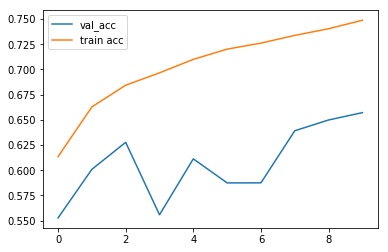

In [56]:
plt.plot(result["history"]["val_binary_accuracy"])
plt.plot(result["history"]["binary_accuracy"])
plt.legend(["val_acc", "train acc"])

In [71]:
logs = np.array(testData)
logs[logs==0] += 1


In [ ]:
logs = np.log10(np.abs(testData.flatten()))

In [64]:
logs = np.nan_to_num(logs)

In [69]:
np.where(logs ==  logs.min())

(array([  2856498,   2856499,   2856998, ..., 285032499, 285032998,
        285032999]),)

In [70]:
testData.flatten()[2856498]

0.0